In [1]:
%%capture
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
!unzip /content/ISIC2018_Task1-2_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
!unzip /content/ISIC2018_Task1_Training_GroundTruth.zip
!pip install scikit-learn==0.24.1
!pip install scikit-multilearn

In [2]:
from skmultilearn.adapt import MLkNN
import numpy as np
import os
import cv2

# Load Data

In [3]:
image_size = 128
path = "./"
train_path = "./ISIC2018_Task1-2_Training_Input"
epochs = 1
batch_size = 19

## Training Ids
train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]
train_ids = [i.split('.', 1)[0] for i in train_ids]
val_data_size = 171

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

smalltrain = train_ids[:1000]
smalltest = train_ids[1000:1300]

trainx = []
trainy = []
testx = []
testy = []
for id in smalltrain:
    im = cv2.imread('./ISIC2018_Task1-2_Training_Input/' + id + '.jpg', 0)
    mask = cv2.imread('./ISIC2018_Task1_Training_GroundTruth/' + id + '_segmentation.png', 0)
    im = cv2.resize(im, (128, 128))
    mask = cv2.resize(mask, (128, 128))
    mask[mask > 0] = 1
    mask[mask <= 0] = 0
    trainx.append(im.flatten())
    trainy.append(mask.flatten())
for id in smalltest:
    im = cv2.imread('./ISIC2018_Task1-2_Training_Input/' + id + '.jpg', 0)
    mask = cv2.imread('./ISIC2018_Task1_Training_GroundTruth/' + id + '_segmentation.png', 0)
    im = cv2.resize(im, (128, 128))
    mask = cv2.resize(im, (128, 128))
    mask[mask > 0] = 1
    mask[mask <= 0] = 0
    testx.append(im.flatten())
    testy.append(mask.flatten())

trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)

# Use MLkNN for Images/Segmentations - SEE ERROR

In [ ]:
#from scipy.sparse import csr_matrix

In [4]:
# ERROR

#trainx = np.array([[255, 34, 2, 89], [233, 40, 94, 12]])
#trainy =  np.array([[1,0,1,0], [1,1,0,1]])
k = int(np.log2(len(trainx)))
#trainx = csr_matrix(trainx)
#trainy = csr_matrix(trainy)
#trainx, trainy.shape
trainx, trainy

(array([[ 19,  20,  23, ...,  14,  13,  11],
        [  8,  10,  22, ...,  99,  85,  73],
        [ 13,  14,  12, ...,  10,   8,   9],
        ...,
        [108, 124, 131, ...,  12,  13,  14],
        [126, 130, 126, ..., 215, 196, 207],
        [179, 173, 176, ..., 183, 180, 172]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [5]:
print('# of samples for trainx = ', trainx.shape)
print('# of samples for trainy = ', trainy.shape)
print('image dimension = ', trainx[0].shape)
print('label dimension = ', trainy[0].shape)
mlknn = MLkNN(k)
mlknn.fit(trainx, trainy)

# of samples for trainx =  (1000, 16384)
# of samples for trainy =  (1000, 16384)
image dimension =  (16384,)
label dimension =  (16384,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=9 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


MLkNN(k=9)

In [6]:
num_classes = len(np.unique(trainy))
missing_label_indices = []
classes = np.array([0,1])
if classes.size != 0 and num_classes < len(classes):
    for idx, label in enumerate(classes):
        if label not in np.unique(trainy):
            missing_label_indices.append(idx)

In [7]:
def predict_proba(testx):
    votes_per_example = mlknn.predict_proba(testx)
    if len(missing_label_indices) > 0:
        for i in missing_label_indices:
            new_col = np.zeros(votes_per_example.shape[0])
            votes_per_example = np.insert(votes_per_example, i, new_col, axis=1)
    return votes_per_example

In [8]:
probs = predict_proba(testx)

In [ ]:
probs

<50x16384 sparse matrix of type '<class 'numpy.float64'>'
	with 819200 stored elements in List of Lists format>

In [9]:
probs = probs.toarray()

In [ ]:
probs

array([[0.00245098, 0.00245098, 0.00245098, ..., 0.00245098, 0.00245098,
        0.00245098],
       [0.00245098, 0.00245098, 0.00245098, ..., 0.00245098, 0.00245098,
        0.00245098],
       [0.00245098, 0.00245098, 0.00245098, ..., 0.00245098, 0.00245098,
        0.00245098],
       ...,
       [0.00245098, 0.00245098, 0.00245098, ..., 0.00245098, 0.00245098,
        0.00245098],
       [0.00245098, 0.00245098, 0.00245098, ..., 0.00245098, 0.00245098,
        0.00245098],
       [0.00245098, 0.00245098, 0.00245098, ..., 0.00245098, 0.00245098,
        0.00245098]])

In [10]:
import matplotlib.pyplot as plt

In [11]:
probs.shape

(300, 16384)

In [13]:
probs[0].shape

(16384,)

Text(0, 0.5, 'Frequency')

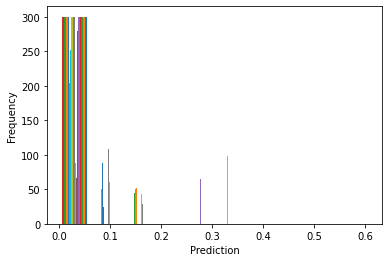

In [12]:
plt.hist(probs)
plt.xlabel('Prediction')
plt.ylabel('Frequency')

In [ ]:
xs = np.array([[i for i in range(probs.shape[1])] for i in range(probs.shape[0])])

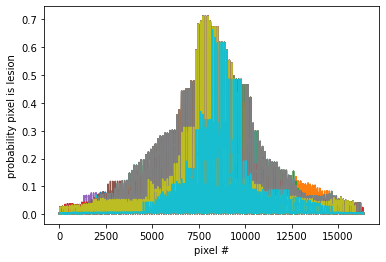

In [ ]:
for x,y in zip(xs, probs):
    plt.plot(x, y)
plt.xlabel('pixel #')
plt.ylabel('probability pixel is lesion')
plt.show()

In [ ]:
#print(classes[np.argmax(predict_proba(testx), axis=3)])
print((probs> 0.5).astype(int))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
